In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2024-02-16 13:03:31.204978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 13:03:31.205137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 13:03:31.222206: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2024-02-16 13:03:31.290673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 13:03:31.290819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


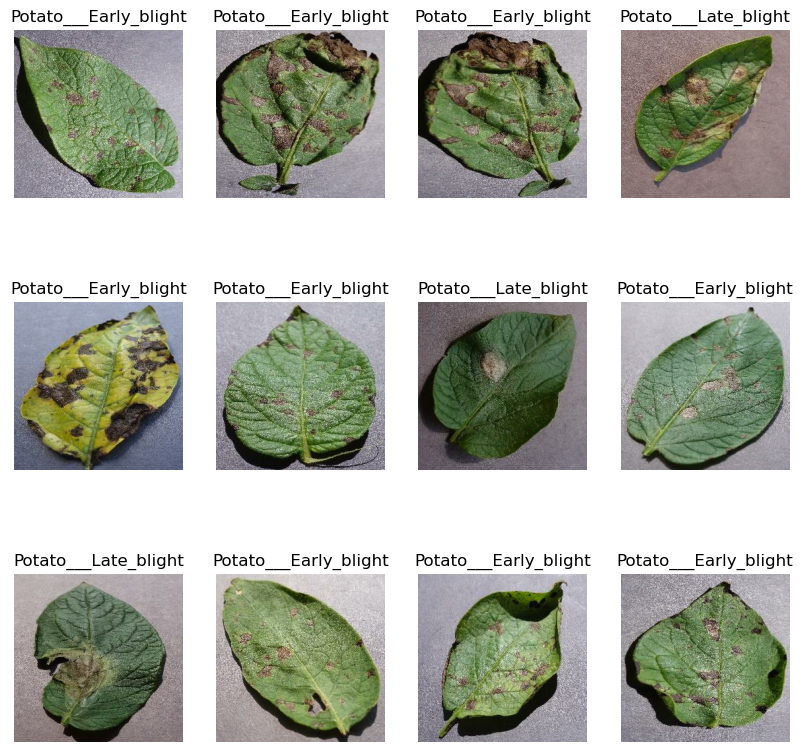

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#going to split the dataset (the length of the dataset is 68 and each element has batch of 32)
# 80% => training 
# 20% => 10% validation (after each epoch this 10% validation dataset is used), 10% for testing
# at the end of every epoch, we use this above 10% validation dataset, in total there will be 50 epochs. 
# only once after the 50 epochs are done, then we use the 10% testing dataset to test the accuracy and performancy
# of the model. 


In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) # you are skipping the first 54 batches and now you considering everything after the first 54 batches
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
# see recommended list of videos as to why suffle size has been set to 10000 in the loop

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
#watch video to understand caching and prefetching-> very important

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# this will read the image from the disk and during the next iteration when the image is required, it will improve memory and improve performance of pipeline 
# prefetch will load the next set of data/images (watch video called preferch and cache in deep learning # 44 tutorial)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# first thing to do in image processing is to scale things first
# numpy is in the range of 255, numpy array is between 0 and 255 (rgb scale), you divide 
# this by 255 to get a number between 0 and 1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) # this will scale the image to whats required (255) I think

In [24]:
# once this layer above is created for our model
# to make the model robust, for example when u try predicting an image but that image is darkened or deformed (upside down)
# also, so if ur model is not robus it would do a bad job in predicting what the model does and hence the goal is now 
# to make the model more robust: we use data augmentation for this (again watch this video as well)
# how it basically works: take one image and create training samples out of it by rotating, horizontally flipping it, 
# changing the contrast, zooming in or out

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
# to summarize what has been done till now in the project: 
# - loaded our dataset into tensorflow dataset
# - did some visualization
# did trai, test and validate 
# created layers for preprocessing of data
# basically we manipulated our data in such a way that it is now ready for model training
# NOW, below we are going to create a Convolutional Neural Network (CNN) and train the network on our train data set 
# and measure accuracy using test dataset
# CNNs are typically used when dealing with image classification models(watch Convolutional Neural Network video also)

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
#the numbers 32, 64, .... represent the number of neurons for each layers
# softmax will normalize the probability of your classes

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


2024-02-16 13:03:31.991472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 13:03:31.991686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.5122

2024-02-16 13:03:59.362676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 13:03:59.362896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 29s 517ms/step - loss: 0.8990 - accuracy: 0.5122 - val_loss: 0.8118 - val_accuracy: 0.6354
Epoch 2/50
54/54 [==============================] - 29s 541ms/step - loss: 0.6511 - accuracy: 0.7303 - val_loss: 0.6072 - val_accuracy: 0.6979
Epoch 3/50
54/54 [==============================] - 30s 561ms/step - loss: 0.3853 - accuracy: 0.8374 - val_loss: 0.3973 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 30s 563ms/step - loss: 0.2805 - accuracy: 0.8929 - val_loss: 0.2546 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 35s 659ms/step - loss: 0.2404 - accuracy: 0.9080 - val_loss: 0.2284 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 61s 1s/step - loss: 0.1367 - accuracy: 0.9468 - val_loss: 0.1688 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 52s 962ms/step - loss: 0.1551 - accuracy: 0.9398 - val_loss: 0.0797 - val_accuracy: 0.9792
Epoch 8/50
54

In [30]:
scores = model.evaluate(test_ds)

2024-02-16 14:17:29.382035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2024-02-16 14:17:29.382725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


8/8 [==============================] - 3s 288ms/step - loss: 0.0788 - accuracy: 0.9961


In [31]:
scores

[0.07884368300437927, 0.99609375]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()
# the 4 parameters are the numbers you get written after running each epoch 
# so since there are 15 epochs that means for all of the 4 parameters there will be 15 values (so in total there would be 60).


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']
# this returns a list of numbers

[0.5121527910232544,
 0.7303240895271301,
 0.8373842835426331,
 0.8929398059844971,
 0.9079861044883728,
 0.9467592835426331,
 0.9398148059844971,
 0.9751157164573669,
 0.9502314925193787,
 0.984375,
 0.984375,
 0.9826388955116272,
 0.9878472089767456,
 0.9814814925193787,
 0.9942129850387573,
 0.9832175970077515,
 0.9965277910232544,
 0.9913194179534912,
 0.8721064925193787,
 0.8651620149612427,
 0.9751157164573669,
 0.9971064925193787,
 0.9959490895271301,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [36]:
# the above can be plotted so as to give better visualization using the matplot library
# understand the difference between accuracy and val_accuracy (personal research for me)
# also do the same for history and val_loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# all of the above basically return a list of all the 15 different values for the respective parameters.

In [37]:
print(val_loss)

[0.8118112683296204, 0.6071588397026062, 0.39729785919189453, 0.2546252906322479, 0.22839684784412384, 0.16879580914974213, 0.07968220114707947, 0.10473812371492386, 0.06508061289787292, 0.018851546570658684, 0.08461745828390121, 0.016467876732349396, 0.3395354747772217, 0.017519528046250343, 0.06037520244717598, 0.025723345577716827, 0.016506945714354515, 0.019133590161800385, 0.605505108833313, 0.03924037888646126, 0.008141939528286457, 0.011973637156188488, 0.0033330677542835474, 0.0015163915231823921, 0.0011649817461147904, 0.0006911948439665139, 0.0008552539511583745, 0.0006248298450373113, 0.0006177567993290722, 0.0005094959633424878, 0.000506468815729022, 0.00042125090840272605, 0.0004268110205885023, 0.0004718203272204846, 0.00034111933200620115, 0.000362133578164503, 0.0002976108225993812, 0.0003257310308981687, 0.00033154411357827485, 0.00024372717598453164, 0.00029668104252777994, 0.00018019431445281953, 0.00015808703028596938, 0.00014948862371966243, 0.00014454344636760652,

Text(0.5, 1.0, 'Training and Validation Loss')

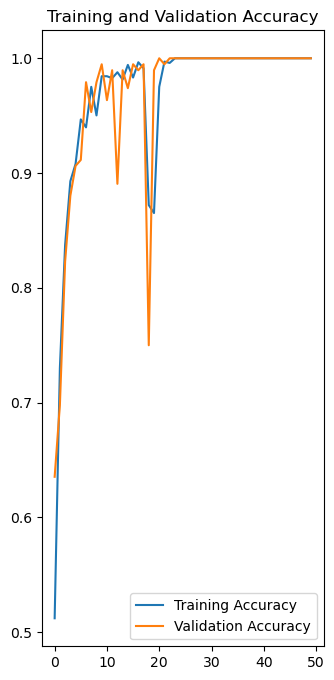

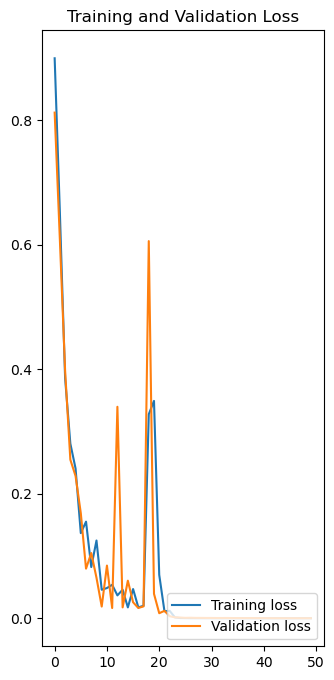

In [38]:
# now below we are going to plot training and validation accuracy 
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# watch a matplot lib tutorial also to understand this even more (do some examples also)
# x-axis has the number of epochs

# plotting the loss chart 
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

# as an extension create that true false graphs (forgot the name check ur ee for more details)

# loss is the error in backpropagation which keeps reducing after each epochs


2024-02-16 14:17:32.833246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2024-02-16 14:17:32.833791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


first image to predict
first image's actual label:, Potato___Late_blight
1/1 [==============================] - 0s 305ms/step
predicted label: Potato___Late_blight


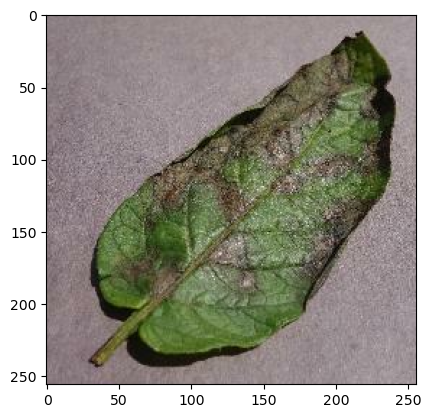

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy()) # this is currently a tensor, to convert it to numpy use the .numpy() method
    #plt.imshow(images_batch[0].numpy().astype('uint8')) # once converted to numpy to show the image from the dataset directly use the astype('uint8') method
    # if you print the image using the print method instead of the plt.imshow then you get a 3 Dimensional array (RGB). Done below:
    #print(images_batch[0].numpy().astype('uint8')) we are gonna save this as a variable 
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:,", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) # this yields a 3 dimensional array because of the architecture of our model, it has 
    # 3 neurons (softmax produces possibility- highest probality is the class.)

In [40]:
# understand the difference between numpy and tensor, both are just ordinary numbers but what is the difference between them

In [41]:
# basically just inputs the model and the image and gives you the predicted class and the confidence (similar to what above cell is doing)
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create batch 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


2024-02-16 14:17:33.370215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2024-02-16 14:17:33.371127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 19ms/step


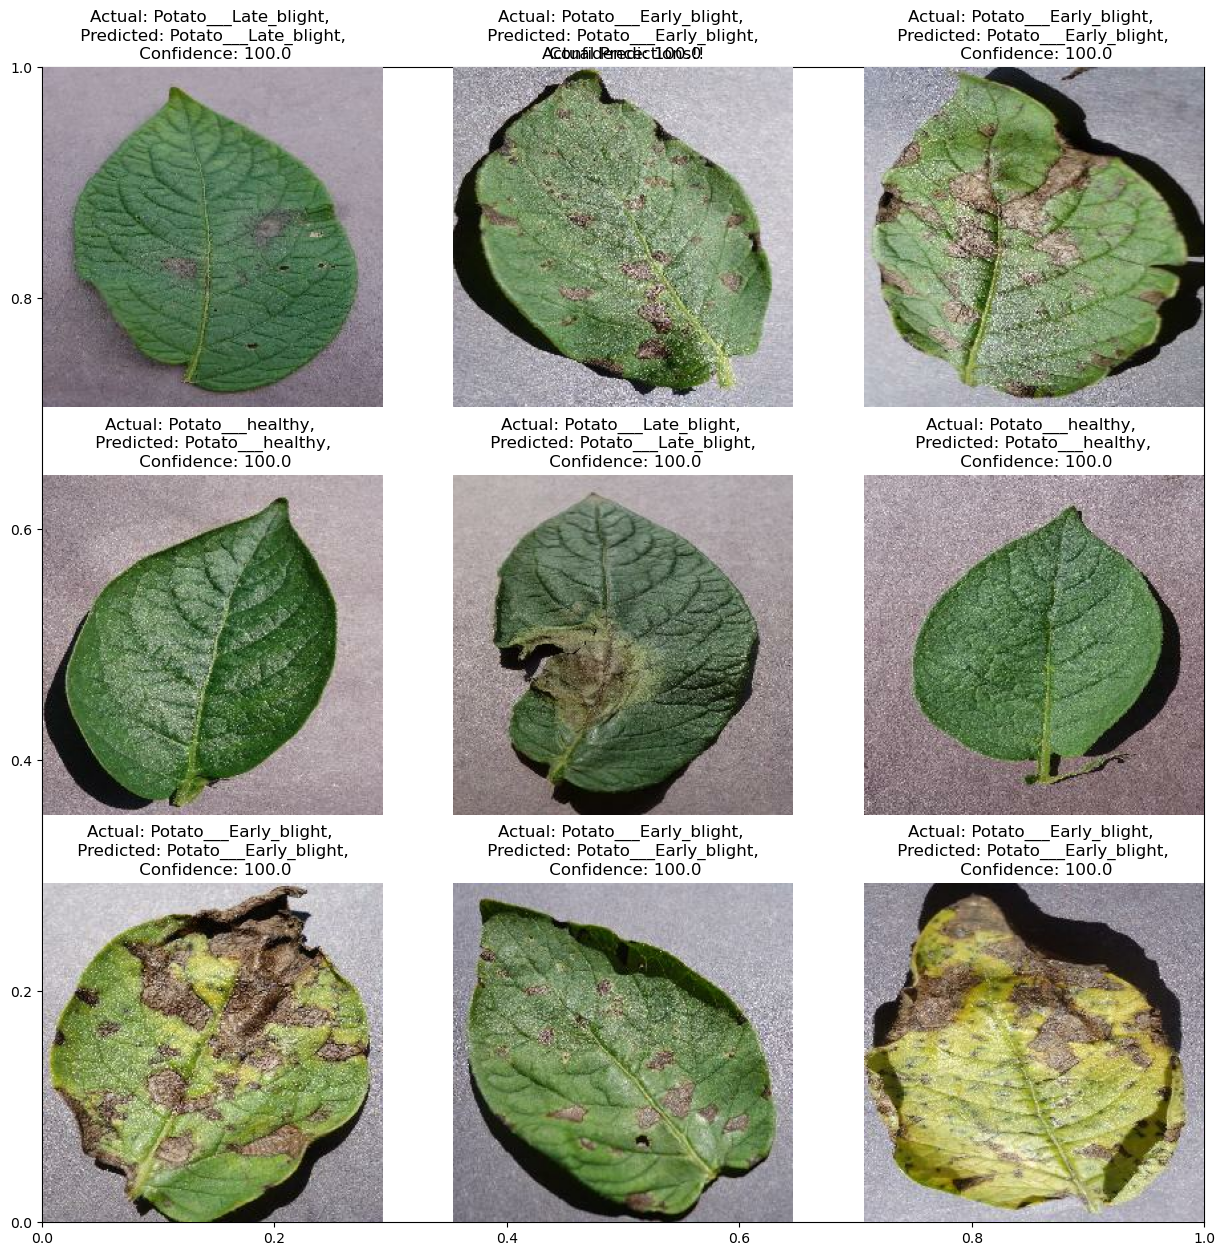

In [42]:
plt.figure(figsize=(15,15)) # this makes the images bigger by increasing their dimensions
plt.title("Actual Predictions!!")
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # to have all of the images you need to have a subplot as well, so below line will not show everything, above line does that for you
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        plt.axis("off")

In [43]:
import os 
[int(i) for i in os.listdir("../models")]

FileNotFoundError: [Errno 2] No such file or directory: '../models'